# Collecting/Processing various gridded datasets to use in CO2 flux models


## fPAR from vegetation indices

Donohue (2014):

`f = 0.95(V-Vn) / (Vx -Vn)`

where Vn and Vx are the minimum (bare soil) and maximum (full cover) NDVI Thresholds.  In the Donohue paper, they use a fixed value of 0.12 and 0.81 for the whole continent.  

Lets test if using kNDVI works better, and let's see if we can use per-pixel derived values for Vn and Vx using the 98% and 2% of the NDVI frequency distributions

I could derive a per-landcover min and max using one of the better landcover dataset

We can derive thresholds by finding the maximum kNDVI over high kNDVI areas, and the opposite for minimum kNDVI.


In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _percentile import xr_quantile

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:

                       chunks={'latitude':1100, 'longitude':1100})


In [ ]:
# quants = ds.quantile([0.02, 0.98], method='nearest')
quants = xr_quantile(ds, quantiles=[0.02,0.98], nodata=np.nan)
quants = quants.compute()

kNDVImin = quants.sel(quantile='0.02').to_array(name='kNDVImin').squeeze().drop('variable')
kNDVImax = quants.sel(quantile='0.98').to_array(name='kNDVImax').squeeze().drop('variable')

#per pixel min max
# fpar = ((ds-kNDVImin)*0.95) / (kNDVImax - kNDVImin)

#invariant min max
fpar = ((ds-kNDVImin.mean().values)*0.95) / (kNDVImax.max().values - kNDVImin.mean().values)
fpar = fpar.persist()

fpar_u = fpar.mean('time').compute()
fpar_1d = fpar.mean(['latitude', 'longitude']).compute()

mod = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FPAR_1km_monthly_2002_2021.nc',
                       chunks={'latitude':1100, 'longitude':1100})
mod = mod.persist()

mod_u = mod.mean('time').compute()
mod_1d = mod.mean(['latitude', 'longitude']).compute()

fig,ax = plt.subplots(1,2, figsize=(25,10))
fpar_u.plot.imshow(ax=ax[0], vmin=0.1, vmax=0.7)
(mod_u/100).plot.imshow(ax=ax[1], vmin=0.1, vmax=0.7)
ax[0].set_title('Mean fPAR derived from kNDVI (2002-2021)')
ax[1].set_title('Mean fPAR from MODIS (2002-2021)')
plt.tight_layout()

fig,ax = plt.subplots(1,1, figsize=(15,5))
fpar_1d.plot(linestyle='-', ax=ax, label='kNDVI fPAR')
(mod_1d/100).plot(linestyle='-', ax=ax, label='MODIS fPAR')
ax.legend(loc='lower right')
ax.set_title('fPAR')

### Process Donohue's fPAR data

kindly sent to me over oneDrive

In [ ]:
import xarray as xr
from datetime import datetime
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
!rm -r -f /g/data/os22/chad_tmp/NEE_modelling/data/fPAR_NDVI/.ipynb_checkpoints

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/fPAR_NDVI/'
j=0
for y in range(2020, 2021):
    print(" {:03}/{:03}\r".format(j + 1, len(range(2002, 2022))), end="")
    _y = str(y)+'/'
    l = []
    for i in os.listdir(base+_y):
        if i.endswith(".tif"):
            l.append(base+_y+i)
    
    arrs=[]
    l.sort()
    for i in l:
        ds = xr.open_dataarray(i, chunks={'x':5000, 'y':5000}).squeeze().drop('band')
        time = datetime.strptime(str(y) + "-" + i[-7:-4], "%Y-%j")
        time = np.datetime64(time)
        ds = ds.expand_dims(time=[time])
        ds = assign_crs(ds, crs='epsg:4326')
        ds = ds.rename('fPAR')
        arrs.append(ds)
        
    dss = xr.concat(arrs, dim='time').sortby('time')
    dss.attrs['nodata'] = np.nan
    da=xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/C4percent_1km_monthly_2002_2021.nc').isel(time=1)
    dss=dss.where(dss>=0)
    ds.attrs['nodata'] = np.nan
    dss = xr_reproject(dss, da.geobox, resampling='average')#.compute()
    dss['latitude'] = dss.latitude.astype('float32')
    dss['longitude'] = dss.longitude.astype('float32')
    dss['latitude'] = np.array([round(i,4) for i in dss.latitude.values])
    dss['longitude'] = np.array([round(i,4) for i in dss.longitude.values])
    dss = dss.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    dss.attrs['nodata'] = np.nan
    dss = dss/1000
    dss=dss.compute()
    dss.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/fPAR_interim/'+str(y)+'.nc')
    j=j+1

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/fPAR_interim/'
ds = xr.open_mfdataset([base+i for i in os.listdir(base) if i.endswith(".nc")])
ds.attrs['nodata'] = np.nan

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FPAR-NDVI_1km_monthly_2002_2021.nc')

In [ ]:
fpar_u = ds.fPAR.mean('time').compute()
fpar_1d = ds.fPAR.mean(['latitude', 'longitude']).compute()

In [ ]:
mod = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FPAR_1km_monthly_2002_2021.nc',
                       chunks={'latitude':1100, 'longitude':1100})
mod = mod.persist()

mod_u = mod.mean('time').compute()
mod_1d = mod.mean(['latitude', 'longitude']).compute()

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,10))
fpar_u.plot.imshow(ax=ax[0], vmin=0.0, vmax=0.8)
(mod_u/100).plot.imshow(ax=ax[1], vmin=0.0, vmax=0.8)
ax[0].set_title('Mean fPAR derived from NDVI (2002-2021)')
ax[1].set_title('Mean fPAR from MODIS (2002-2021)')
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(15,5))
fpar_1d.plot(linestyle='-', ax=ax, label='NDVI fPAR')
(mod_1d/100).plot(linestyle='-', ax=ax, label='MODIS fPAR')
ax.legend(loc='lower right')
ax.set_title('fPAR')

## Bioclimatic regions from RECAPP

Yohanna sent these files as `.hdr`, converted into a netcdf with `gdal_translate -of netCDF reccap6ctr05.flt bioclimatic_regions.nc`

In [19]:
import xarray as xr
from odc.geo.xr import assign_crs
import numpy as np
import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_vectorize

import contextily as cx
import matplotlib.pyplot as plt

In [20]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc')

In [21]:
ds = ds.rename('bioclimatic_regions')

In [22]:
ds = assign_crs(ds, crs='epsg:4326')

In [23]:
df = xr_vectorize(ds, attribute_col='bioclimatic_regions')

In [24]:
df = df.dissolve(by='bioclimatic_regions', aggfunc='mean').reset_index()

In [25]:
# df.plot(column='bioclimatic_regions', legend=True)

In [26]:
df['region_name'] = 0
df['region_name'] = np.where(df['bioclimatic_regions']==1.0, 'Tropics', df['region_name'])
df['region_name'] = np.where(df['bioclimatic_regions']==2.0, 'Savanna', df['region_name'])
df['region_name'] = np.where(df['bioclimatic_regions']==3.0, 'Warm Temperate', df['region_name'])
df['region_name'] = np.where(df['bioclimatic_regions']==4.0, 'Cool Temperate', df['region_name'])
df['region_name'] = np.where(df['bioclimatic_regions']==5.0, 'Mediterranean', df['region_name'])
df['region_name'] = np.where(df['bioclimatic_regions']==6.0, 'Desert', df['region_name'])
df

,bioclimatic_regions,geometry,region_name
0,1.0,"MULTIPOLYGON (((122.92500 -16.42500, 122.92500...",Tropics
1,2.0,"MULTIPOLYGON (((147.67500 -19.87500, 147.72500...",Savanna
2,3.0,"MULTIPOLYGON (((145.42500 -36.02500, 145.42500...",Warm Temperate
3,4.0,"MULTIPOLYGON (((147.07500 -43.37500, 147.12500...",Cool Temperate
4,5.0,"MULTIPOLYGON (((135.82500 -34.87500, 135.82500...",Mediterranean
5,6.0,"MULTIPOLYGON (((113.57500 -26.67500, 113.57500...",Desert


In [27]:
# df.to_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

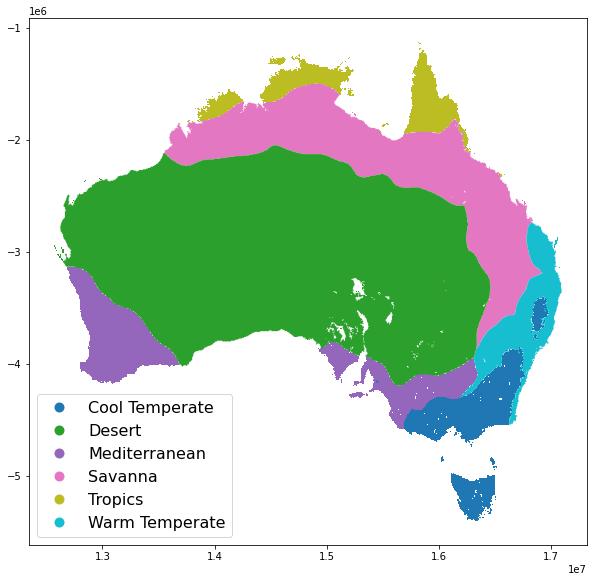

In [41]:
df.plot(column='region_name', legend=True, figsize=(10,10), legend_kwds={'loc':'lower left', 'fontsize':16})
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/bioclimatic_regions.png')

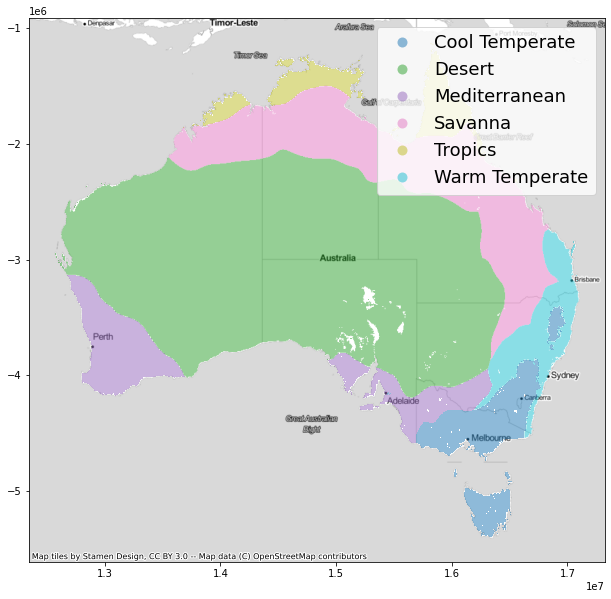

In [29]:
df = df.to_crs(epsg=3857) #web map mercartor to match basemap tiles

fig, ax = plt.subplots(figsize=(20, 10))
df.plot(column='region_name', ax=ax, legend=True, alpha=0.5, legend_kwds={'loc':'best', 'fontsize':18})
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
# cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels);
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/bioclimatic_regions.png')

## PET

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
from odc.algo import xr_reproject

In [ ]:
i=0
arrs = []
for y in range(2002, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(2002, 2022))), end="")
    y = str(y)
    ds = xr.open_dataarray('https://dapds00.nci.org.au/thredds/dodsC/iu04/australian-water-outlook/v1-0/historical/v1/ET/pen_pet_'+y+'.nc')
    ds = assign_crs(ds, crs='epsg:4326')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).sum()
    ds.attrs['nodata'] = np.nan
    
    da=xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/data_5km.nc')['LST'].isel(time=1)
    da = (~np.isnan(da))
    da = da.rename({'x':'longitude', 'y':'latitude'})
    ds = xr_reproject(ds, da.geobox, resampling='nearest')#.compute()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
    ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])
    ds = ds.where(da)
    arrs.append(ds)
    i+=1

dss = xr.concat(arrs, dim='time').sortby('time')
dss

In [ ]:
dss.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/5km/PET_5km_monthly_2002_2021.nc')

In [ ]:
dss = dss.astype(np.float32)

In [ ]:
# dss.plot.imshow(col='time', col_wrap=6)

## Urban mask

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
from odc.algo import xr_reproject

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
ds = xr.open_dataarray('https://dapds00.nci.org.au/thredds/dodsC/ub8/au/LandCover/OzWALD_LC/GUF_FractionUrban_Australia.nc'+'#fillmismatch')

In [ ]:
ds = assign_crs(ds, crs='epsg:4326')
ds.attrs['nodata'] = np.nan
ds = ds.chunk({'longitude':1000, 'latitude':1000})
ds = ds.transpose('latitude', 'longitude') #coordinates are incorrectly ordered

In [ ]:
da = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/C4percent_1km_monthly_2002_2021.nc')
ds = xr_reproject(ds, da.geobox, resampling='average')#.compute()
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')
ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])

In [ ]:
ds = ds.compute()

In [ ]:
ds = xr.where(ds>=25, 1, 0)

In [ ]:
ds.astype('int8').rename('urban_mask').to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/urban_mask_1km.nc')

## SIF soundings

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import allNaN_arg

In [ ]:
df = pd.read_parquet('/g/data/os22/chad_tmp/NEE_modelling/data/sif/oco2_oco3_summarized_Australia_2014-09-01_2021-12-01.parquet')
df.head(20)

In [ ]:
df = df.set_index(['xc','yc','d_ym'])
df = df.groupby(['xc','yc','d_ym']).mean()
# df = df[~df.index.duplicated(keep=False)]
ds = df.to_xarray()
ds = ds.transpose()

da = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/C4percent_1km_monthly_2002_2021.nc')
ds['d_ym'] = da.sel(time=slice(ds.d_ym[0].values, ds.d_ym[-1].values)).time.values

ds = ds.rename({'d_ym':'time', 'xc':'longitude', 'yc':'latitude'})
ds_annual = ds.resample(time='1Y').mean()

In [ ]:
ds_annual.dsif_u.plot.imshow(col='time', col_wrap=5, vmin=0, vmax=0.5)

In [ ]:
n_obs_monthly = ds['dsif_nobs'].groupby('time.month').sum()
# n_obs_monthly.where(n_obs_monthly>50).plot.imshow(col='month', col_wrap=4, robust=True)

In [ ]:
monthly_mean = ds.groupby('time.month').mean()

In [ ]:
max_mean_month = allNaN_arg(monthly_mean.dsif_u.where(n_obs_monthly>0), 'month', 'max')

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(12,8), sharey=True)
im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax, cmap='twilight', add_colorbar=False)
cbar = plt.colorbar(im, spacing='uniform', ax=ax)
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=20)
ax.set_title('Month of maximum SIF');
plt.tight_layout();

In [ ]:
monthly_mean.dsif_u.mean(['latitude', 'longitude']).plot()

## Resampling GRAFS and LAI to monthly

In [ ]:
i=0
for y in range(2018, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(2018, 2022))), end="")
    
    year = str(y)
    
    sws = xr.open_dataset('/g/data/fj4/SatelliteSoilMoistureProducts/S-GRAFS/ANNUAL_NC/surface_soil_moisture_vol_1km_'+year+'.nc',
                      chunks=dict(lat=1000, lon=1000))
    sws = assign_crs(sws, crs=sws.attrs['crs'][-9:])
    sws = sws.soil_moisture.where(sws >=0)
    sws = sws.soil_moisture.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().compute()
    sws = sws.rename({'lat':'latitude', 'lon':'longitude'})
    sws.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/GRAFS/GRAFS_1km_monthly_'+year+'.nc')
    i+=1
    
i=0
for y in range(2016, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(2016, 2022))), end="")
    
    year = str(y)
    
    base = '/g/data/ub8/au/MODIS/mosaic/MOD15A2H.006/'
    lai = xr.open_dataset('/g/data/ub8/au/MODIS/mosaic/MOD15A2H.006/MOD15A2H.006.b02.500m_lai.'+year+'.nc',
                          chunks=dict(latitude=1000, longitude=1000))
    lai = assign_crs(lai, crs='epsg:4326')
    lai = lai['500m_lai'].rename('lai') #tidy up the dataset
    lai = lai.where((lai <= 10) & (lai >=0)) #remove artefacts and 'no-data'
    lai = lai.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().compute() # resample to monthly
    lai.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/LAI/LAI_500m_monthly_'+year+'.nc')
    i+=1

## Woody Cover /  Above ground Biomass / Woody height

Albert's paper: https://www.sciencedirect.com/science/article/pii/S0303243420304189

Mosaics: https://dapds00.nci.org.au/thredds/catalog/ub8/au/LandCover/OzWALD_LC/catalog.html

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
from odc.algo import xr_reproject

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
# ds = xr.open_dataset('https://dapds00.nci.org.au/thredds/dodsC/ub8/au/LandCover/OzWALD_LC/VegH_2007-2010_mosaic_AustAlb_25m.nc')
ds = xr.open_dataset('/g/data/ub8/au/LandCover/OzWALD_LC/VegH_2007-2010_mosaic_AustAlb_25m.nc')
ds = ds.transpose('y', 'x') #coordinates are incorrectly ordered
ds = assign_crs(ds, crs='epsg:3577')
ds = ds.drop('crs')
ds = ds['VegH']
ds.attrs['nodata'] = np.nan
ds = ds.chunk({'x':1000, 'y':1000})
ds

In [ ]:
da = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/C4percent_1km_monthly_2002_2021.nc')
ds = xr_reproject(ds, da.geobox, resampling='average')#.compute()
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')
ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])

In [ ]:
ds = ds.compute()

In [ ]:
ds.plot.imshow(size=10, robust=True)

In [ ]:
ds = ds.expand_dims(time=da.sel(time=slice('2002','2021')).time)

ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/VegH_1km_monthly_2002_2021.nc')

## Fire emissions (GFAS)

From WALD https://dapds00.nci.org.au/thredds/catalog/ub8/au/FireEmissions/catalog.html

In [ ]:
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
from odc.algo import xr_reproject

In [ ]:
years = [str(i) for i in range(2003,2022)]
i=0
p=[]
for y in years:
    print(" {:02}/{:02}\r".format(i + 1, len(years)), end="")
    ds = xr.open_dataset('https://dapds00.nci.org.au/thredds/dodsC/ub8/au/FireEmissions/GFASv12.BurntCarbon.'+y+'.nc').BurntCarbon
    ds = ds.transpose('time', 'latitude', 'longitude') #coordinates are incorrectly ordered
    ds = assign_crs(ds, crs='epsg:4326') # set the right projection
    ds = xr_reproject(ds, geobox=ds.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear') #convert to equal area
    ds = ds * ds.geobox.resolution[1]**2 * 1e-15 #convert to a total carbon flux in petagrams
    ds_m = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).sum() #resample daily values to monthly sums
    ds_m.attrs['units'] = 'PgC'
    ds_m=ds_m.rename('Fire Emissions (PgC)')
    p.append(ds_m)
    i+=1

ds = xr.concat(p, dim='time').sortby('time')
ds

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2021.nc')

In [ ]:
# ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2021.nc')

In [ ]:
# (ds*1000).resample(time='Y').sum().sum(['x', 'y']).to_series().plot.bar(figsize=(11,4))

## ANUClim Climate data (1 x 1km)

In [ ]:
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
import os
from odc.algo import xr_reproject

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
%%time
base='/g/data/gh70/ANUClimate/v2-0/stable/month/'
var = 'evap' #vpd, #srad, #rain #evap

years = [str(i) for i in range(2002,2022)]

i=0
pp = []
for y in years:
    print(" {:02}/{:02}\r".format(i + 1, len(years)), end="")
    ds = xr.open_mfdataset([base+var+'/'+y+'/'+i for i in os.listdir(base+var+'/'+y+'/')],
                              chunks=dict(lat=1000, lon=1000))
    
    ds = assign_crs(ds, crs='epsg:4283') #GDA94
    ds = ds.drop('crs')[var]
    ds.attrs['nodata'] = np.nan
    attrs = ds.attrs
    
    da = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc')
    ds = xr_reproject(ds, da.geobox, resampling='nearest')#.compute()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
    ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])
    ds.attrs = attrs
    pp.append(ds)
    i+=1

ds = xr.concat(pp, dim='time').sortby('time')
ds

In [ ]:
ds = ds.compute()

In [ ]:
# ds.isel(time=111).plot.imshow(size=6)

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/'+var+'_1km_monthly_2002_2021.nc')

## ANUCLIM DEM

In [ ]:
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
import os
from odc.algo import xr_reproject

In [ ]:
ds = xr.open_dataset('https://dapds00.nci.org.au/thredds/dodsC/gh70/ANUClimate/v2-0/topogrid/dem01/ANUClimate_v2-0_dem01.nc').squeeze().drop('time')
ds

In [ ]:
ds = assign_crs(ds, crs='epsg:4283')

In [ ]:
ds = ds.drop('crs')
ds = ds['dem01']
ds=ds.where(ds>-200)

In [ ]:
# ds.attrs['nodata'] = np.nan
    
da = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc')
ds = xr_reproject(ds, da.geobox, resampling='nearest')#.compute()
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')
ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])

In [ ]:
ds

In [ ]:
ds = ds.expand_dims(time=da.sel(time=slice('2002','2021')).time)

In [ ]:
ds = ds.rename('elevation')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/Elevation_1km_monthly_2002_2021.nc')

## Month of year

In [ ]:
import xarray as xr
import numpy as np

In [ ]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/Elevation_1km_monthly_2002_2021.nc')
moy = ds.time.dt.month

In [ ]:
moy = moy.expand_dims(latitude=ds.latitude, longitude=ds.longitude)
moy = moy.astype(np.float32)
mask = ~np.isnan(ds.isel(time=1))
moy = moy.where(mask)
moy = moy.rename('month')

In [ ]:
# moy.isel(time=range(0,18)).plot.imshow(col='time', col_wrap=6)

In [ ]:
moy.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MOY_1km_monthly_2002_2021.nc')

## Cumulative (Climatological) Water Deficit, Moisture Index

Using rainfall from ANUClim and ET-actual from CMRSET

CWD:

        CWD for month n = CWDn-1 + Pn - ETn, where ET is fixed at 100mm/month
        When CWD>0, CWD = 0
        CWDn = CWDn-1 + Pn- 100

Moisture Index:

        P/ET

In [ ]:
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

In [ ]:
rain = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/rain_1km_monthly_2002_2021.nc')
et = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/ETa_1km_monthly_2002_2021.nc')

### CWD

In [ ]:
N = len(rain.time.values)
times=list(rain.time.values)
# ET = 100

In [ ]:
#intialize the first time-step
intial = rain.isel(time=0) - et.isel(time=0)
intial = xr.where(intial>0, 0, intial) # Max CWD value is zero
rain.loc[dict(time=times[0])] = intial

In [ ]:
intial.plot.imshow(robust=True)

In [ ]:
#loop through remaining time-steps
i=0
for i in range(1, N):
    print(" {:02}/{:02}\r".format(i + 1, N), end="")
    
    #add rainfall to previous time-step, then subtract ET
    da = rain.isel(time=i-1) + rain.isel(time=i) - et.isel(time=i) 
    # reset max value to 0
    da = xr.where(da>0, 0, da)
    # add array in-place
    rain.loc[dict(time=times[i])] = da
    i+=1

In [ ]:
rain = rain.rename('CWD')
rain.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/CWD_1km_monthly_2002_2021.nc')

In [ ]:
rain.mean(['latitude', 'longitude']).plot(figsize=(11,4))

## Moisture Index

* Large value (>1) means rainfall greatly exceeds ET and therefore no moisture stress
* Value <1 mean ET exceeds rainfall, therefore moisture stress

Should use PET not ETa

In [ ]:
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

In [ ]:
# rain = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/rain_1km_monthly_2002_2021.nc')
rain = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/chirps_5km_monthly_1991_2021.nc').sel(time=slice('2002','2021'))
# et = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/ETa_1km_monthly_2002_2021.nc')

#pan evaporation from ANUClim
# et = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/evap_1km_monthly_2002_2021.nc')

#Penman PET from AWRA
et = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/PET_5km_monthly_2002_2021.nc')

In [ ]:
rain = xr_reproject(rain, et.geobox, resampling='nearest')
rain['latitude'] = rain.latitude.astype('float32')
rain['longitude'] = rain.longitude.astype('float32')
rain['latitude'] = np.array([round(i,4) for i in rain.latitude.values])
rain['longitude'] = np.array([round(i,4) for i in rain.longitude.values])

In [ ]:
mi = rain/et

In [ ]:
mi = xr.where(mi>10, 10, mi)

In [ ]:
mi.plot.hist(bins=100, xlim=(0,10));

In [ ]:
mi.isel(time=range(0,12)).plot.imshow(col='time', col_wrap=6, robust=True)

In [ ]:
mi = mi.rename('MI')
mi.attrs['nodata'] = np.nan
mi.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/5km/MI_15km_monthly_2002_2021.nc')

## Vegetation Optical Depth

Global long-term Vegetation optical depth climate-data aggregate VODCA

In [ ]:
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
import os
from odc.algo import xr_reproject

In [ ]:
year_start = 2002
year_end = 2003
base = '/g/data/os22/chad_tmp/NEE_modelling/data/VOD/C-Band/'
out = '/g/data/os22/chad_tmp/NEE_modelling/data/VOD/VOD_AUS/'

In [ ]:
i=0
for y in range(year_start, year_end+1):
    print(" {:02}/{:02}\r".format(i + 1, len(range(year_start, year_end+1))), end="")
    
    year = str(y)
    files = os.listdir(base+year)
    ds = xr.open_mfdataset([base+year+'/'+f for f in files]).sel(lon=slice(110,155), lat=slice(-9,-45)).vod
    ds = assign_crs(ds, crs='epsg:4326')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().compute()
    ds.to_netcdf(out+'VODCA_'+year+'.nc')
    i+=1

In [ ]:
files = os.listdir(out)
ds = xr.open_mfdataset([out+f for f in files]).vod
ds = ds.astype('float32')
ds.attrs['nodata'] = np.nan
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/VOD/VOD_25km_monthly_2002_2018.nc')

Resample to 5km

In [ ]:
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/5km/chirps_5km_monthly_1991_2021.nc')
ds = xr_reproject(ds, chirps.geobox, resampling='bilinear').compute()
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/5km/VOD_5km_monthly_2002_2018.nc')

## Stitch together GO-SIF GPP

Li, X., Xiao, J. (2019) Mapping photosynthesis solely from solar-induced chlorophyll fluorescence: A global, fine-resolution dataset of gross primary production derived from OCO-2. Remote Sensing, 11(21), 2563; https://doi.org/10.3390/rs11212563.

We used the global, OCO-2-based SIF product (GOSIF) and linear relationships between SIF (Solar-induced chlorophyll fluorescence) and GPP to map GPP globally at a 0.05° spatial resolution and 8-day time step for the period from 2000 to 2018. To account for the uncertainty of GPP estimates resulting from the SIF-GPP relationship, we used eight SIF-GPP relationships (universal and biome-specific, with and without intercept) at both site and grid cell levels to estimate GPP. All the eight SIF-GPP relationships performed well in estimating GPP globally. The ensemble mean 8-day GPP was generally highly correlated with flux tower GPP for 91 eddy covariance flux sites across the globe (R2 = 0.74, RMSE = 1.92 g C m−2 d−1).

In [ ]:
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
import os
from odc.algo import xr_reproject

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/GOSIF_GPP/'

arrs=[]
files = os.listdir(base)
i = 0
for f in files:
    print(" Tif {:03}/{:03}\r".format(i + 1, len(files)), end="")
    if f.endswith('.tif'):
        y=f[-17:-13]
        m=f[-11:-9]
        sif = rioxarray.open_rasterio(base+f).squeeze().drop('band').sel(x=slice(110,155)).sel(y=slice(-8,-45))
        time=pd.date_range(np.datetime64(y+'-'+m), periods=1, freq="MS") + pd.Timedelta(14, 'd')
        sif = sif.expand_dims(time=time) 
        sif = sif.where(sif < 65534) # clean up dataset
        sif = sif * 0.01 #scale for monthly GPP
        ## reproject to 5km resolution
        sif.name = 'GOSIF_GPP_gC_m2_month'
        sif = assign_crs(sif, crs='epsg:4326')
        sif.attrs['nodata'] = np.nan
        chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/5km/chirps_5km_monthly_1991_2021.nc')
        sif = xr_reproject(sif, chirps.geobox, resampling='bilinear').compute()
        sif['latitude'] = sif.latitude.astype('float32')
        sif['longitude'] = sif.longitude.astype('float32')
        arrs.append(sif.astype('float32'))
        i += 1

In [ ]:
sif = xr.concat(arrs, dim='time').sortby('time')

In [ ]:
sif.isel(time=110).plot.imshow(size=8, robust=True);

In [ ]:
sif

In [ ]:
sif.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')

## MODIS Land surface temp

In [ ]:
import xarray as xr
from odc.geo.xr import assign_crs
import os
import pandas as pd

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
base='/g/data/ub8/au/MODIS/mosaic/MYD11A1.006/'
files = os.listdir(base)
paths = [base+i for i in files if not 'QC' in i]

In [ ]:
%%time
for p in paths[2:]:
    y=p[-7:-3] #year
    print(y)
    lst = xr.open_dataset('/g/data/ub8/au/MODIS/mosaic/MYD11A1.006/MYD11A1.006.LST_Day_1km.'+y+'.nc',
                          chunks=dict(latitude=1000, longitude=1000))
    lst = assign_crs(lst, crs='epsg:4326')
    lst = lst.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean().compute()
    lst = lst.LST_Day_1km.rename('LST')
    lst.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/LST/LST_MODIS_1km_month_'+y+'.nc')
    

## MODIS fPAR from GEE

https://github.com/aazuspan/wxee/blob/main/docs/examples/image_collection_to_xarray.ipynb

https://github.com/aazuspan/wxee/blob/main/docs/examples/modis.ipynb

In [ ]:
# !pip install earthengine-api
# !pip install wxee

In [ ]:
import ee
import wxee
import xarray as xr
import rioxarray
from odc.geo.xr import assign_crs
import pandas as pd
import numpy as np
import os
from odc.algo import xr_reproject

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [ ]:
# ~Aus region (slightly less to trick google into giving me 1km res)
region = ee.Geometry.Polygon([[
            [114,-43.0],
            [153.0,-43.0],
            [153.0,-10.0],
            [114,-10.0],
            [114,-43.0]]])

### Loop through months and resample 4-day fPAR MODIS data

In [ ]:
#use start and end dates to loop through months and load GEE FPAR data
start = pd.date_range(start='7/1/2002', end='12/1/2021', freq='MS') 
end = pd.date_range(start='7/1/2002', end='12/31/2021', freq='M')

i = 0
for s, e in zip(start,end):
    
    print(" {:03}/{:03}\r".format(i + 1, len(start)), end="")
    
    #use this to check if file already exists
    ss = s+pd.Timedelta(14, 'd')
    if os.path.isfile('/g/data/os22/chad_tmp/NEE_modelling/data/FPAR/FPAR_'+ss.strftime('%Y-%m-%d')+'.nc'):
        pass
    
    else:
        try:
            s = s.strftime('%Y-%m-%d')
            e = e.strftime('%Y-%m-%d')

            #download data from GEE
            ts = wxee.TimeSeries("MODIS/061/MCD15A3H").filterDate(s, e)
            ts = ts.select(["Fpar"])
            ds = ts.wx.to_xarray(region=region, scale=1000, crs="EPSG:3577", progress=False) #download at 1km res

            attrs=ds.attrs #extract attributes so we don't loose them
            ds = assign_crs(ds, crs='epsg:3577') #add geobox
            ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean() #resample to monthly
            ds = ds.Fpar #convert to dataarray

            lst = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/LST/LST_2002.nc').isel(time=0) #use this to reproject too
            ds = xr_reproject(ds, geobox=lst.geobox, resampling='bilinear') #reproject
            ds = ds.where(ds!=0) # remove spurious zeros from reprojection
            ds = ds.assign_attrs(attrs) #add back attrs
            ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/FPAR/FPAR_'+np.datetime_as_string(ds.time.values[0], unit='D')+'.nc')

        except:
            print('fail:', s,e)
            pass
        
    i+=1

### Stitch together monthly files into annual netcdfs

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/FPAR/'
i=0
for y in range(2002, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(2002, 2023))), end="")
    
    year = str(y)
    files = [base+f for f in os.listdir(base) if year in f]
    
    dss=[]
    for f in files:
        ds = xr.open_dataset(f)
        dss.append(ds)
        
    data = xr.concat(dss, dim='time').sortby('time')
    data.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/FPAR_annual/FPAR_MODIS_1km_'+year+'.nc')
    
    i+=1

##  Standardized Precipitation Evapotranspiration Index

Using CHIRPS 5km as input data and  python `climate_indices` on the command line

#### Create long time-series of rainfall using ANUCLIM

superseeded by CHIRPS rainfall on 5km grid

In [ ]:
# base='/g/data/gh70/ANUClimate/v2-0/stable/month/'
# years = [str(i) for i in range(2002,2021)]

# pp = []
# for y in years:
#     precip = xr.open_mfdataset([base+'rain/'+y+'/'+i for i in os.listdir(base+'rain/'+y+'/')],
#                               chunks=dict(lat=1000, lon=1000))
#     precip = assign_crs(precip, crs='epsg:4283') #GDA94
#     precip = precip.drop('crs').rain
#     # precip = precip.rename({'lat':'latitude', 'lon':'longitude'})
#     pp.append(precip)

# precip = xr.concat(pp, dim='time').sortby('time')
# del precip.attrs['grid_mapping']
# precip.attrs['units'] = 'mm'
# precip = precip.to_dataset()
# precip.to_zarr('/g/data/os22/chad_tmp/NEE_modelling/data/SPI/rainfall_2002_2020.nc')

AWRA

In [ ]:
import xarray as xr
tair = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc')
tair = tair.rename({'latitude':'lat', 'longitude':'lon'})
tair.temp_avg_month.attrs['units'] = 'celsius'
tair.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/SPEI/tair.nc')

In [ ]:
rain = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')
rain = rain.rename({'latitude':'lat', 'longitude':'lon'})
rain.precip.attrs['units'] = 'mm'
rain.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/SPEI/rain.nc')

CHIRPS

In [ ]:
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps-v2.0.monthly.nc').sel(time=slice('1991','2021'))
ds['time'] = ds.time + np.timedelta64(14,'D') #centre times
ds = ds.sel(latitude=slice(-45,-9), longitude=slice(110,155)) # select Aus
ds = assign_crs(ds, crs='epsg:4326')

#reproject to AWRA grid to align with temp etc.
awra = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/rain_monthly_1991_2021.nc')
ds = xr_reproject(ds, awra.geobox, 'nearest') 
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')
print(ds)
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')

#### Use `climate_indices` command line to calculate PET

In [ ]:
import xarray as xr

In [ ]:
tair = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/tavg_1km_monthly_2002_2021.nc')

# tair = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc')
tair = tair.rename({'latitude':'lat', 'longitude':'lon'})
tair.tavg.attrs['units'] = 'celsius'
tair.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/tair.nc')

In [ ]:
import os
os.system("process_climate_indices "\
       "--index pet "\
       "--periodicity monthly "\
       "--netcdf_temp /g/data/os22/chad_tmp/NEE_modelling/data/1km/tair.nc "\
       "--var_name_temp tavg "\
       "--output_file_base /g/data/os22/chad_tmp/NEE_modelling/data/1km/ "\
       "--multiprocessing all "
         )

#### Use `climate_indices` command line to calculate SPI

In [ ]:
# scales= < 6 produces NaNs in some places
import os
os.system("process_climate_indices "\
       "--index spei "\
       "--periodicity monthly "\
       "--netcdf_precip /g/data/os22/chad_tmp/NEE_modelling/data/SPEI/rain.nc "\
       "--var_name_precip precip "\
       "--netcdf_pet /g/data/os22/chad_tmp/NEE_modelling/data/SPEI/_pet_thornthwaite.nc "\
       "--var_name_pet pet_thornthwaite "\
       "--output_file_base /g/data/os22/chad_tmp/NEE_modelling/data/SPEI/ "\
       "--scales 6 "\
       "--calibration_start_year 1991 "\
       "--calibration_end_year 2021 "\
       "--multiprocessing all "
         )

## AWRA Climate

/g/data/fj8/BoM/AWRA/DATA/CLIMATE/g/data/fj8/BoM/AWRA/DATA/CLIMATE

In [ ]:
import xarray as xr
import pandas as pd
from odc.geo.xr import assign_crs

#### Solar radiation

Data comes as MJ/m2/day, converting to W/m2 by dividing by 0.0864 (86400 seconds in the day; 1,000,000 J to a MJ, so 86400/1x10^6 = 0.0864)

total solar Swi

In [ ]:
var='solar_exposure_day'

aa = []
for y in range(2000, 2022):
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds / 0.0864 #convert to W/m2
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/solar_monthly_wm2_2000_2021.nc')

#### Rainfall

In [ ]:
var='rain_day'

aa = []
for y in range(1991, 2022)[0:1]:
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).sum()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = ds.rename({'rain_day':'rain_month'})
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/rain_monthly_1991_2021.nc')

#### Temperature


Calculating daily Tavg using `(tmax+tmin)/2`, then aggreating daily Tavg to monthly mean Tavg.

In [ ]:
var='temp_max_day'

aa = []
for y in range(2000, 2022):
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = ds.rename({'temp_max_day':'temp_max_month'})
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tmax_monthly_2000_2021.nc')

In [ ]:
var='temp_min_day'

aa = []
for y in range(2000, 2022):
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = ds.rename({'temp_min_day':'temp_min_month'})
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tmin_monthly_2000_2021.nc')

In [ ]:
aa = []
i=0
for y in range(1991, 2022):
    print(" {:03}/{:03}\r".format(i + 1, len(range(1991, 2022))), end="")
    year = str(y)
    tmax = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/temp_max_day/temp_max_day_'+year+'.nc').temp_max_day
    tmax['latitude'] = tmax.latitude.astype('float32')
    tmax['longitude'] = tmax.longitude.astype('float32')
    tmin = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/temp_min_day/temp_min_day_'+year+'.nc').temp_min_day
    tmin['latitude'] = tmin.latitude.astype('float32')
    tmin['longitude'] = tmin.longitude.astype('float32')
    tavg = (tmax+tmin)/2
    tavg = tavg.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    tavg.name = 'temp_avg_month'
    aa.append(tavg)
    i+=1
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc')

#### Vapour pressure

In [ ]:
var='vapour_pressure'

aa = []
for y in range(2000, 2022):
    year = str(y)
    ds = xr.open_dataset('/g/data/fj8/BoM/AWRA/DATA/CLIMATE/'+var+'/'+var+'_'+year+'.nc')
    ds = assign_crs(ds, crs='epsg:4236')
    ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    ds = ds.rename({'vapour_pressure':'vapour_pressure_month'})
    aa.append(ds)
    
ds = xr.concat(aa, dim='time').sortby('time')
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/vp_monthly_2000_2021.nc')

#### Vapour pressure deficit



In [ ]:
import xarray as xr
import numpy as np

In [ ]:
ta = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc').sel(time=slice('2000','2021'))
vp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/vp_monthly_2000_2021.nc').sel(time=slice('2000','2021'))

sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
vpd = sat_vp - vp

vpd.name = 'VPD'
vpd.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/vpd_monthly_2000_2021.nc')

## Difference between Land surface and air temperature



In [ ]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
tair = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/tavg_1km_monthly_2002_2021.nc',
                         chunks=dict(latitude=1000, longitude=1000))

lst = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/LST_1km_monthly_2002_2021.nc',
                     chunks=dict(latitude=1000, longitude=1000)).LST

In [ ]:
deltaT = (lst-273.15) - tair
deltaT

In [ ]:
deltaT.name = 'LST-Tair'
deltaT.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/LST_Tair_1km__monthly_2002_2021.nc')

## FLUXCOM

Downloaded from https://www.bgc-jena.mpg.de/geodb/projects/DataDnld.php

Using RS-METEO driven by ERA5, ensemble of three ML models.

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import os
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
rm -r -f /g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/rs/nee/.ipynb_checkpoints

In [13]:
var='nee'
VAR='NEE'

In [14]:
base = '/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/rs/'+var+'/'
files = os.listdir(base)
ds = xr.open_mfdataset([base+f for f in files]).sel(longitude=slice(110,155), latitude=slice(-10.25,-45))

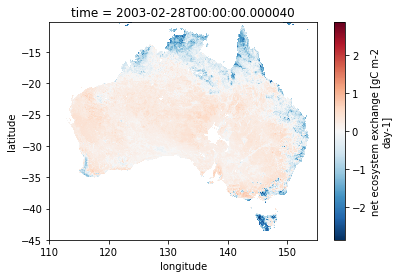

In [15]:
ds[VAR].isel(time=1).plot.imshow()

In [16]:
ds = assign_crs(ds, crs='epsg:4326')

In [17]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+VAR+'_rs.nc')

## Global Canopy Height

Requires dask to complete, but result is poor...not sure what's going on


In [ ]:
import rioxarray
import xarray as xr
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs
from datacube.utils.dask import start_local_dask

client = start_local_dask(mem_safety_margin='2Gb')
print(client)

In [ ]:
ds = rioxarray.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/forest_height/Forest_height_2019_AUS.tif').squeeze().drop('band')
ds = assign_crs(ds, crs='epsg:4236')
ds = ds.rename({'y':'latitude', 'x':'longitude'})
ds = ds.chunk(dict(latitude=1000,longitude=1000))

In [ ]:
# open a dataset to get geobox to project too (1 km resolution)
lst = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/LST/LST_2019.nc').isel(time=0)
lst = lst.chunk(dict(latitude=1000,longitude=1000))

In [ ]:
ds = xr_reproject(ds, geobox=lst.geobox, resampling='average').compute()

In [ ]:
ds.name = 'forest_height_AUS'

ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/forest_height/Forest_height_1km_2019_AUS.nc')

## MODIS Landcover

MCD12Q1.006_500m

In [ ]:
import xarray as xr
import numpy as np
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
lc = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/MCD12Q1.006_500m_aid0001.nc').squeeze()['LC_Type5']
lc = lc.rename({'lat':'latitude', 'lon':'longitude'})
attrs = lc.attrs

#open chrips (reproject to this)
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')


In [ ]:
lc.attrs

Reclassify

In [ ]:
lc = xr.where(lc==1, 2, lc) # ENL to EBF
lc = xr.where(lc==3, 2, lc) # DNL to EBF
lc = xr.where(lc==4, 2, lc) # DBL to EBF
lc = xr.where(lc==8, 7, lc) # Broadleaf crop to Cereal crop
lc = xr.where(lc==11, 5, lc) # barren to grass
lc = xr.where(lc==0, np.nan, lc) # Water to no-data
lc = xr.where(lc==9, np.nan, lc) # urban to no-data
lc = xr.where(lc==10, np.nan, lc) # snow to no-data

In [ ]:
#reproject
lc = assign_crs(lc, crs='epsg:4326')
lc = xr_reproject(lc, chirps.geobox, resampling='mode')

# make into a time-series
lc = lc.expand_dims(time=chirps.sel(time=slice('2002','2021')).time)
lc = lc.rename('IGBP_class')
lc.attrs = attrs
lc.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/IGBP_Landcover_MODIS_5km.nc')

## Carbon Tracker Gridded Fluxes

Global surface fluxes at 1x1-degree spatial resolution in netCDF format. Provided as flux components: fossil fuel emissions, land biosphere NEE excluding fires, wildfire emissions, and air-sea exchange. CarbonTracker allows for any type of flux to happen at any grid location, so users are cautioned that they may want to sum flux components to get total surface CO2 exchange with the atmosphere. This convention admits land fluxes from islands in the ocean, for instance, or air-water exchange from inland lakes and seas

https://gml.noaa.gov/ccgg/carbontracker/

https://gml.noaa.gov/aftp/products/carbontracker/co2/fluxes/monthly/

In [ ]:
import xarray as xr
import numpy as np

In [ ]:
ct = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/carbontracker/CT2019B.flux1x1-monthly.nc', drop_variables='time_components').sel(time=slice('2003','2018'))
ct.data_vars

In [ ]:
ct_aus = ct.sel(longitude=slice(110,155), latitude=slice(-46,-9))
# ct_aus.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/carbontracker/CarbonTracker_NEE_AUS_monthly_2000_2018.nc')

In [ ]:
ct_aus.bio_flux_opt.sel(time='2011').plot.imshow(col='time', col_wrap=6, cmap='RdBu_r', robust=True);

In [ ]:
annual_mean = ct_aus.bio_flux_opt.groupby('time.year').sum().mean('year')
annual_std = ct_aus.bio_flux_opt.groupby('time.year').sum().std('year')

In [ ]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,2, figsize=(25,10))
annual_mean.plot.imshow(ax=ax[0], robust=True)
annual_std.where(annual_std>0).plot.imshow(ax=ax[1], cmap='magma', robust=True)
ax[0].set_title('Carbon Tracker Annual Mean NEE, 2003-2018')
ax[1].set_title('Carbon Tracker Annual Std. in NEE, 2003-2018')
# plt.suptitle('Annual Mean and Std. Dev. of GPP, 2003-2021')
plt.tight_layout();

In [ ]:
ds_1D = ct_aus.bio_flux_opt.sum(['longitude','latitude'])

In [ ]:
ds_1D.plot(figsize=(15,5), marker='o', linestyle='--')
plt.axhline(0, c='grey')
plt.title('Carbon Tracker monthly NEE, 2003-2018');
# plt.ylabel('gC/m2/month');

In [ ]:
ds_1D_annual = ds_1D.resample(time='1Y').sum()
ds_1D_annual.plot(figsize=(15,5), marker='o', linestyle='--')
plt.axhline(0, c='grey')
plt.title('Carbon Tracker Annual NEE, 2003-2018');
# plt.ylabel('gC/m2/year');

In [ ]:
monthly_mean = ct_aus.bio_flux_opt.groupby('time.month').mean()
monthly_std = ct_aus.bio_flux_opt.groupby('time.month').std()

In [ ]:
y = monthly_mean.sum(['longitude','latitude']).values
x = monthly_mean.month.values
std = monthly_std.sum(['longitude','latitude']).values

fig,ax = plt.subplots(1,1, figsize=(9,4))
ax.plot(x, y, marker='o', linestyle='--')
ax.axhline(0, c='grey')
ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Carbon Tracker Monthly Mean NEE averaged over Australia')
ax.set_xlabel('Month');
# ax.set_ylabel('gC/m2/month');

## Merge ESA Worldcover with GFSAD cropmask

GDAL isn't installed???

In [ ]:
import xarray as xr
import numpy as np
import rioxarray as rxr
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs


In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
lc = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/ESA_worldcover_1km.nc')
geobox = lc.geobox

In [ ]:
lc = xr.where(lc==60, 30, lc) # barren to grassland
lc = xr.where(lc==80, np.nan, lc) # Water to no-data
lc = xr.where(lc==50, np.nan, lc) # urban to no-data
lc = xr.where(lc==90, 20, lc) # wetland to shrubland
lc = xr.where(lc==95, 10, lc) # mangroves to trees

In [ ]:
cm = rxr.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/GFSAD_cropmask_mosaic.tif', chunks=dict(x=1000, y=1000)).squeeze().drop('band')
cm = cm.rename({'x':'longitude', 'y':'latitude'})
cm = assign_crs(cm, crs='epsg:4326')
cm = cm.astype(np.int8)

In [ ]:
#reproject
cm = xr_reproject(cm, geobox, resampling='mode')
cm

In [ ]:
cm = cm.compute()

In [ ]:
cm = xr.where(cm==2, 40, np.nan) # reclassify to match ESA cropland class
cm.plot.imshow(size=6)

In [ ]:
lc_merged = xr.where(np.isnan(cm), lc, cm)#.plot.imshow(size=10) 

In [ ]:
lc_merged.plot.imshow(size=10);

In [ ]:
#open chrips (reproject to this)
evi = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc')

In [ ]:
lc_merged = xr_reproject(assign_crs(lc_merged, crs='epsg:4326'), evi.geobox, resampling='mode')

# make into a time-series
lc_merged = lc_merged.expand_dims(time=evi.sel(time=slice('2002','2021')).time)
lc_merged = lc_merged.rename('PFT')
lc_merged.astype(np.float32)
lc_merged.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/Landcover_1km_monthly_2002_2021.nc')

In [ ]:
import xarray as xr
import odc.geo
import folium
from odc.geo.xr import assign_crs

In [ ]:
lc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/Landcover_merged_5km.nc').isel(time=1), crs='epsg:4326')

In [ ]:
# # Create folium Map (ipyleaflet is also supported)
# m = folium.Map()

# # Plot each sample image with different colormap
# lc.PFT.odc.add_to(m, opacity=1.0, cmap='Paired')

# # Zoom map to Australia
# m.fit_bounds(lc.odc.map_bounds())

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = True,
#         control = True
#        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)

In [ ]:
lc.PFT.plot.imshow(size=10)

## MODIS EVI to 5km grid

In [ ]:
import os
import xarray as xr
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
base = '/g/data/os22/chad_tmp/NEE_modelling/data/EVI_annual/'
ds = xr.open_mfdataset([base+i for i in os.listdir(base)], chunks=dict(time=1))

In [ ]:
#open chrips (reproject to this)
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')

ds = xr_reproject(ds, geobox=chirps.geobox, resampling='nearest')
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')

In [ ]:
ds = ds.compute()

In [ ]:
ds.EVI.isel(time=200).plot.imshow(size=8, vmin=0);

In [ ]:
ds = ds.astype('float32')

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/EVI_5km_monthly_2002_2021.nc');

## Aridity Index

In [ ]:
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs
import rioxarray
import numpy as np
import xarray as xr

In [ ]:
ai = rioxarray.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/ai_v3_yr.tif').squeeze().drop('band').isel(x=range(35000,40500), y=range(11750,16250))

In [ ]:
ai = assign_crs(ai, crs='epsg:4326')

In [ ]:
ai = ai / 10000

In [ ]:
#open chrips (reproject to this)
evi = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc')

ai = xr_reproject(ai, evi.geobox, resampling='average')
ai['latitude'] = ai.latitude.astype('float32')
ai['longitude'] = ai.longitude.astype('float32')

# make into a time-series
ai = ai.expand_dims(time=evi.sel(time=slice('2002','2021')).time)
ai = ai.rename('AI')

In [ ]:
ai.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/AridityIndex_1km_monthly_2002_2021.nc')

## Terra Climate Water balance datasets

https://climatedataguide.ucar.edu/climate-data/terraclimate-global-high-resolution-gridded-temperature-precipitation-and-other-water

In [ ]:
from odc.algo import xr_reproject
import pandas as pd
from odc.geo.xr import assign_crs
import rioxarray
import numpy as np
import xarray as xr

In [ ]:
base= 'http://thredds.northwestknowledge.net/thredds/dodsC/TERRACLIMATE_ALL/data/'
year_start = 2021
year_end = 2021

In [ ]:
i=0
for y in [2003, 2005, 2012, 2013]: #range(year_start, year_end+1):
    y = str(y)
    print(y)
    pet = xr.open_dataset(base+'TerraClimate_pet_'+y+'.nc').isel(lat=slice(2375,3250), lon=slice(6900,8100)).drop('crs')
    pet = pet['pet']
    pet = pet.rename('PET')
    pet.attrs['nodata'] = np.nan
    pet = assign_crs(pet, crs='epsg:4326')
    attrs = pet.attrs
    pet = pet.compute()
    pet['time'] = pet.time + pd.Timedelta(14, 'd')

    ppt = xr.open_dataset(base+'TerraClimate_ppt_'+y+'.nc').isel(lat=slice(2375,3250), lon=slice(6900,8100)).drop('crs')
    ppt = ppt['ppt']
    ppt = ppt.rename('precip')
    ppt.attrs['nodata'] = np.nan
    ppt = assign_crs(ppt, crs='epsg:4326')
    attrs = ppt.attrs
    ppt = ppt.compute()
    ppt['time'] = ppt.time + pd.Timedelta(14, 'd')

    ds = ppt/pet
    
#     ds = xr.open_dataset(base+'TerraClimate_def_'+y+'.nc').isel(lat=slice(2375,3250), lon=slice(6900,8100)).drop('crs')
#     ds = ds['def']
#     ds = ds.rename('CWD')
#     ds.attrs['nodata'] = np.nan
#     ds = assign_crs(ds, crs='epsg:4326')
#     attrs = ds.attrs
#     ds = ds.compute()
#     ds['time'] = ds.time + pd.Timedelta(14, 'd')
    
    ## reproject to 5km resolution
    chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')
    ds = xr_reproject(ds, chirps.geobox, resampling='bilinear').compute()
    ds['latitude'] = ds.latitude.astype('float32')
    ds['longitude'] = ds.longitude.astype('float32')
    
    ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/Moisture_index/Moisture_index_5km_monthly_'+y+'.nc')

In [ ]:
rm -r -f /g/data/os22/chad_tmp/NEE_modelling/data/Moisture_index/.ipynb_checkpoints

In [ ]:
import os
base='/g/data/os22/chad_tmp/NEE_modelling/data/Moisture_index/'
xx = xr.open_mfdataset([base+i for i in os.listdir(base)]).astype('float32').rename({'__xarray_dataarray_variable__':'MI'})
xx

In [ ]:
xx.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/Moisture_index_5km_monthly_2002_2021.nc')

In [ ]:
# xx = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/Moisture_index_5km_monthly_2002_2021.nc')

In [ ]:
#2003-07 to 2003-12
#2005-01 to 2005-12
#2012-09 to 2012-12
#2013-10 to 2013-12

In [ ]:
xx = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/Moisture_index/Moisture_index_5km_monthly_2015.nc')
xx

In [ ]:
xx.MI.sel(time='2013').plot.imshow(col='time', robust=True, col_wrap=4);

## Create 1 km gridded datasets

for remote sensing variables so pixels extraction over EC towers is more representative 

ToDO:

* ~~EVI~~
* ~~LAI~~
* ~~LST~~
* ~~FPAR~~
* ~~Tree~~, ~~non-tree~~, ~~no-veg~~
* ~~TWI~~
* Landcover

In [ ]:
import os
import xarray as xr
import numpy as np
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=18)

In [ ]:
client

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/Tree_cover/'
var='Percent_Tree_Cover'

In [ ]:
ds = xr.open_mfdataset([base+i for i in os.listdir(base)], chunks=dict(time=1)).astype('float32').persist()
ds

In [ ]:
#compute climatology
clim = ds[var].chunk(dict(latitude=750, longitude=750))
clim = ds.groupby("time.month").mean("time").compute()

# fill nans with climatology and plot cloudiest period
ds = ds.groupby("time.month").fillna(clim)

In [ ]:
ds[var].isel(time=104).plot.imshow(robust=True);

In [ ]:
ds[var].attrs['nodata'] = np.nan #need to add this so xr_reproject doesn't include in reprojection
ds.attrs['nodata'] = np.nan
ds

In [ ]:
ds = ds.rename({var:'FPAR'}).drop('month')
ds

In [ ]:
%%time
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FPAR_1km_monthly_2002_2021.nc')

## Fill no-data values in MODIS variables with climatology

In [ ]:
import os
import xarray as xr
import numpy as np
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [ ]:
cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=18)

In [ ]:
client

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/EVI/'
var='EVI'

In [ ]:
ds = xr.open_mfdataset([base+i for i in os.listdir(base)], chunks=dict(time=1)).astype('float32').persist()
ds

In [ ]:
ds[var].isel(time=110).plot.imshow(vmin=0)

In [ ]:
#compute climatology
clim = ds[var].chunk(dict(latitude=750, longitude=750))
clim = ds.groupby("time.month").mean("time").compute()

In [ ]:
# clim.Lai.plot.imshow(col='month')

In [ ]:
# fill nans with climatology and plot cloudiest period
ds = ds.groupby("time.month").fillna(clim)

# ds[var].isel(time=104).plot.imshow(vmin=0)

In [ ]:
ds[var].isel(time=110).plot.imshow(robust=True)

In [ ]:
## reproject to 5km resolution
chirps = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc') # open chrips (reproject to this)

ds[var].attrs['nodata'] = np.nan #need to add this so xr_reproject doesn't include in reprojection
ds.attrs['nodata'] = np.nan

ds_rp = xr_reproject(ds, chirps.geobox, resampling='average', dst_nodata=np.nan).compute()
ds_rp['latitude'] = ds_rp.latitude.astype('float32')
ds_rp['longitude'] = ds_rp.longitude.astype('float32')

In [ ]:
ds_rp[var].isel(time=110).plot.imshow(robust=True, size=10)

In [ ]:
ds_rp

In [ ]:
# ds = ds.fillna(0)

In [ ]:
ds_rp = ds_rp.rename({'Fpar':'FPAR'})

In [ ]:
ds_rp

In [ ]:
ds_rp.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/EVI_5km_monthly_2002_2021.nc')

## Cumulative rainfall

In [ ]:
import xarray as xr
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [ ]:
cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=18)

In [ ]:
client

In [ ]:
rain = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/rain_1km_monthly_2002_2021.nc',
                        chunks=dict(latitude=1000, longitude=1000))

In [ ]:
rain_cml_3 = rain.rolling(time=3, min_periods=3).sum()
rain_cml_3 = rain_cml_3.rename('rain_cml3')

In [ ]:
rain_cml_6 = rain.rolling(time=6, min_periods=6).sum()
rain_cml_6 = rain_cml_6.rename('rain_cml6')

In [ ]:
rain_cml_12 = rain.rolling(time=12, min_periods=12).sum()
rain_cml_12 = rain_cml_12.rename('rain_cml12')

In [ ]:
rain_cml_3.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/rain_cml3_1km_monthly_2002_2021.nc')

In [ ]:
rain_cml_6.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/rain_cml6_1km_monthly_2002_2021.nc')

In [ ]:
rain_cml_12.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/rain_cml12_1km_monthly_2002_2021.nc')

## Fractional Anomalies

    (obs - climatology) / climatology
    


kNDVI, LAI, rain_cml3, rain_cml6, rain_cml12, NDWI

In [ ]:
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [ ]:
cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=18)

In [ ]:
client

In [ ]:
var = 'srad'
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/'+var+'_1km_monthly_2002_2021.nc',
                      chunks=dict(latitude=1200, longitude=1200))

In [ ]:
mean = ds.groupby("time.month").mean("time")

In [ ]:
frac = ds.groupby("time.month") / mean
# frac = frac.groupby("time.month") / mean

In [ ]:
frac=frac.compute()

In [ ]:
frac.drop('month').rename(var+'_anom').to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/'+var+'_anom_1km_monthly_2002_2021.nc')

In [ ]:
frac.mean(['latitude', 'longitude']).plot(figsize=(11,4))

## Topographic Moisture index

Values of TWI larger than about 12 are most likely in channels or extremely flat areas where the physical concepts behind TWI are invalid and probably are not useful for measuring relative wetness, topographic position or any other geomorphic property. Contributing area (for channels) and MrVBF are more likely to be useful indicators of geomorphic properties in these areas. See, for example, McKenzie, Gallant and Gregory (2003) where soil depth is estimated using TWI on hillslopes and MrVBF in flat valley floors: the range of validity for TWI in that example was approximately 4.8 to somewhat beyond 8.5.

In [ ]:
import os
import xarray as xr
import rioxarray as rxr
import numpy as np
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster


In [ ]:
cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=18)

In [ ]:
client

In [ ]:
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/twi_3s.tif').squeeze().drop('band')
ds = assign_crs(ds, crs='epsg:4326')
ds.attrs['nodata'] = ds.attrs['_FillValue']

In [ ]:
# ds = ds.chunk(dict(x=1000, y=1000))

In [ ]:
## reproject to 1km resolution
evi = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc') # open chrips (reproject to this)
ds = xr_reproject(ds, evi.geobox, resampling='average').compute()
ds

In [ ]:
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')

In [ ]:
# ds.plot.imshow(robust=True)

In [ ]:
#mask
mask = (ds!=ds.attrs['nodata'])
ds = ds.where(mask)

ds = ds.expand_dims(time=evi.sel(time=slice('2002', '2021')).time)
ds = ds.rename('TWI')
ds = ds.astype('float32')

In [ ]:
ds.attrs['nodata'] = np.nan

### Clip to 10 to prevent very high, invalid TWI values

In [ ]:
ds = xr.where(ds>10, 10, ds)

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/TWI_1km_monthly_2002_2021_.nc')

In [1]:
import xarray as xr

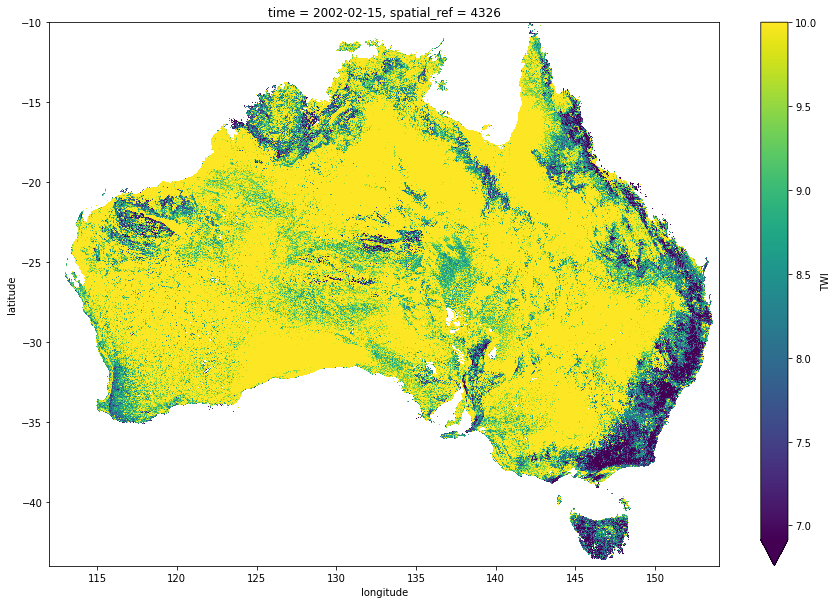

In [4]:
xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/TWI_1km_monthly_2002_2021.nc').isel(time=1).plot.imshow(size=10, robust=True)

## MODIS Vegetation continous fields

In [ ]:
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

In [ ]:
path = '/g/data/os22/chad_tmp/NEE_modelling/data/NonVegetated_cover/'
band = 'Percent_NonVegetated'
rename = 'nonveg_cover'

In [ ]:
year_start = 2021
year_end = 2021

In [ ]:
i=0
for y in range(year_start, year_end+1):
    #print(" {:02}/{:02}\r".format(i + 1, len(range(year_start, year_end+1))), end="")
    year = str(y)
    print(year)
    ds = xr.open_dataset(path+'MOD44B_'+'2020'+'.nc').squeeze().drop('time')
    ds[band].attrs['nodata'] = np.nan #need to add this so xr_reproject doesn't include in reprojection
    ds.attrs['nodata'] = np.nan
    
    ## reproject to 5km resolution
    evi = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc')
    
    # ds = xr_reproject(ds, chirps.geobox, resampling='average', dst_nodata=np.nan).compute()
    # ds['latitude'] = ds.latitude.astype('float32')
    # ds['longitude'] = ds.longitude.astype('float32')
    
    #mask
    mask = ~np.isnan(evi.EVI.isel(time=0).squeeze().drop('time'))
    ds = ds.where(mask)
    
    ds = ds[band].expand_dims(time=evi.sel(time=year).time)
    ds = ds.rename(rename)
    ds = ds.astype('float32')

    ds.to_netcdf(path+'monthly/'+year+'.nc')


In [ ]:
import os

In [ ]:
!rm -r -f /g/data/os22/chad_tmp/NEE_modelling/data/NonVegetated_cover/monthly/.ipynb_checkpoints

In [ ]:
base = '/g/data/os22/chad_tmp/NEE_modelling/data/NonVegetated_cover/monthly/'
files = os.listdir(base)

paths = [base+f for f in files]

ds = xr.open_mfdataset(paths).compute()

In [ ]:
clim = ds.groupby("time.month").mean("time")
ds = ds.groupby("time.month").fillna(clim)

In [ ]:
ds = ds.drop('month')
ds/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/NonVeg_1km_monthly_2002_2021.nc')

## Soil and Landscape grids

In [1]:
import xarray as xr
import numpy as np
import rioxarray as rxr
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/SOC_1km_monthly_2002_2021.nc').isel(time=1)

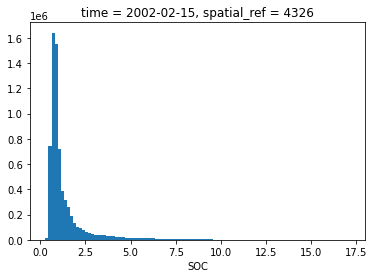

In [7]:
ds.plot.hist(bins=100);#imshow(size=10, robust=True)

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/SOC/SOC_000_005_EV_N_P_AU_NAT_C_20140801.tif',
                      chunks=dict(x=5000, y=5000)).squeeze().drop('band')
ds = assign_crs(ds, crs='epsg:4326')
ds = ds.rename('SOC')
ds = ds.where(ds>-1)
ds.attrs['nodata'] = np.nan
ds

In [ ]:
## reproject to 1km resolution
da = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/1km/tavg_1km_monthly_2002_2021.nc')
ds = xr_reproject(ds, da.geobox, resampling='average')
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')
ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])
ds = ds.compute()
ds

In [ ]:
ds.plot.imshow(size=10);

In [ ]:
ds = ds.expand_dims(time=da.sel(time=slice('2002', '2021')).time)


In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/SOC_1km_monthly_2002_2021.nc')

## MODIS 'Months Since Burnt'

In [ ]:
import os
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [ ]:
cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='01:00:00')
client = Client(cluster)
cluster.scale(cores=12)

In [ ]:
client

### Stitch together files downloaded from GEE

product  `"MODIS/006/MCD64A1"`, band `BurnDate`

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/BurnDate/'
files = os.listdir(base)
ds = xr.open_mfdataset([base+f for f in files]).persist()
ds

### Reclassify DOY values to binary

If burnt at all during the a given month, then 1, else 0.

In [ ]:
ds = ds > 0

### Loop through each month in the time-series

* In the first month of the time-series (Jan 2002) we reclassify all the 0 (not burnt) values to 120 (assume 10 years of no-disturbance)
* Then, for each month thereafter if there is no burn, then the count is iterated by 1 i.e. if not burnt Feb 2002 pixel will be 121, etc. If the pixel is burnt, then the count is set back to 0 whereby it will begin counting upwards from zero again.
* After the loop is finished, any pixel that is greater-than 120, is set back to 120. In this way, areas undisturbed by fire have a maxium value of 120 (10 years of being undistrubed by fire), and pixels distrurbed by fire have a value between 0 (just burnt), and 119 (burnt 9 years, 11 months ago).

In [ ]:
i=0
results = []
for t in range(0,len(ds.time)): 
    print(" {:02}/{:02}\r".format(i + 1, len(ds.time)), end="")
    
    time = ds.isel(time=t).time.values
    
    if t>0:
        
        da = ds.BurnDate.isel(time=t)
        da = xr.where(da==0, results[t-1]+1, 0)
    
    else:
    
        time = ds.isel(time=t).time.values
        da = ds.BurnDate.isel(time=t)
        da = xr.where(da==0, 120 , 0) #what should the starting value be? 0 or some larger number?
    
    da = da.squeeze().drop('time')
    da = da.expand_dims(time=[time])
    
    results.append(da.astype('int16').rename('Months_since_burn'))
    
    i+=1

ds = xr.concat(results, dim='time').sortby('time')
ds = xr.where(ds > 120, 120, ds).compute()

In [ ]:
evi = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/EVI_1km_monthly_2002_2021.nc').isel(time=0)
ds = ds.astype('float32').where(~np.isnan(evi))

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FireDisturbance_1km_monthly_2002_2021.nc')

### Mask pixels that are on average > 50 % trees (using MODIS VCF)

In [ ]:
tree = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/Tree_1km_monthly_2002_2021.nc',
                         chunks=dict(latitude=1000, longitude=1000)).mean('time').compute()
tree = tree >= 50
ds = ds.astype('float32').where(tree)
ds.attrs['nodata'] = np.nan

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FireDisturbanceTrees_1km_monthly_2002_2021.nc')

### Reproject to 5km resolution

In [ ]:
evi = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/EVI_5km_monthly_2002_2021.nc').isel(time=0) #use this to reproject too
ds.attrs['nodata'] = np.nan
ds = xr_reproject(assign_crs(ds, crs='epsg:4326'), geobox=evi.geobox, resampling='average') #reproject
ds['latitude'] = ds.latitude.astype('float32')
ds['longitude'] = ds.longitude.astype('float32')
ds

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/5km/FireDisturbance_5km_monthly_2002_2021.nc')

### Animate (for fun)

In [ ]:
import sys
import xarray as xr
import geopandas as gpd
from IPython.display import Image
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.plotting import xr_animation

In [ ]:
ds = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/FireDisturbanceTrees_1km_monthly_2002_2021.nc'), crs='epsg:4326')

In [ ]:
ds = ds.isel(latitude=range(2000,3000), longitude=range(3200,4200))#.isel(time=1).plot.imshow()
ds

In [ ]:
poly_gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/aus_outline/AUS_2021_AUST_GDA2020.shp')
poly_gdf =  poly_gdf[poly_gdf['AUS_CODE21']=='AUS']

In [ ]:
ds.sel(time=slice('2003','2021')).to_dataset()

In [ ]:
path = '/g/data/os22/chad_tmp/NEE_modelling/results/figs/fireDisturbance.gif'
poly_gdf['color'] = 'None'
ds.attrs['nodata'] = np.nan

xr_animation(ds.to_dataset(), #isel(time=range(6,240))
            bands=['Months_since_burn'],
            show_date='%b %Y',
            width_pixels=600,
            output_path=path,
            colorbar_kwargs={'colors': 'black'},
            # show_gdf=poly_gdf,
            interval=200, 
            show_text='Months since burnt',
            # gdf_kwargs={'edgecolor': 'grey', 'linewidth':0.5}, 
            imshow_kwargs={'cmap': 'RdYlGn', 'vmin': 0, 'vmax': 120}
            )

# Plot animation
plt.close()
Image(path, embed=True)

## kNDVI

In [ ]:
import os
import xarray as xr
import numpy as np
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
# !rm -r -f /g/data/os22/chad_tmp/NEE_modelling/data/ETa/.ipynb_checkpoints

In [ ]:
base='/g/data/os22/chad_tmp/NEE_modelling/data/kndvi/'
files = os.listdir(base)
files.sort()

In [ ]:
time = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/ETa_1km_monthly_2002_2021.nc').time.values
time = list(time)

In [ ]:
i=0
arrs=[]
for f, t in zip(files, time):
    print(" {:02}/{:02}\r".format(i + 1, len(files)), end="")
    ds = xr.open_dataarray(base+f, chunks=dict(x=5000, y=5000)).squeeze().drop('band').astype('float32')
    ds = ds.expand_dims(time=[t])
    ds = ds.rename('kNDVI')
    ds.attrs['nodata']=np.nan
    del ds.attrs['long_name']
    ds = ds.drop('spatial_ref')
    ds = assign_crs(ds, crs='epsg:3577')
    i+=1 
    arrs.append(ds)

In [ ]:
ds = xr.concat(arrs, dim='time').sortby('time')
ds

In [ ]:
da = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/tavg_1km_monthly_2002_2021.nc').isel(time=0) #use this to reproject too
ds = xr_reproject(ds, geobox=da.geobox, resampling='bilinear') #reproject

ds['latitude'] = ds.latitude.astype('float32')
ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
ds['longitude'] = ds.longitude.astype('float32')
ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])


In [ ]:
ds.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/kNDVI_1km_monthly_2002_2021.nc')

In [ ]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/kNDVI_1km_monthly_2002_2021.nc',
                      chunks=dict(latitude=750, longitude=750, time=-1))

In [ ]:
ds = ds.interpolate_na(method='linear', dim='time', limit=2).compute()#.isel(time=110).plot.imshow(size=10)

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/kNDVI_1km_monthly_2002_2021.nc')

## CO2

In [ ]:
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/g/data/os22/chad_tmp/NEE_modelling/data/CapeGrim_CO2_data.csv')
df['time']=pd.to_datetime(df[['year', 'month', 'day']])
df=df.set_index('time').drop(['year', 'month', 'day'], axis=1).rename({'CO2(ppm)':'CO2'}, axis=1)
df.head()

In [ ]:
df = df.resample('MS',loffset=pd.Timedelta(14, 'd')).mean()

In [ ]:
ds = xr.Dataset.from_dataframe(df)
ds

In [ ]:
ds = ds.sel(time=slice('2002', '2021'))

In [ ]:
ds.CO2.plot(figsize=(11,4));

In [ ]:
da=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/kNDVI_1km_monthly_2002_2021.nc')
ds = ds.expand_dims(latitude=da.latitude, longitude=da.longitude)
ds = 

In [ ]:
# ds.co2.isel(time=range(0,12)).plot.imshow(col='time', col_wrap=4);

In [ ]:
ds.astype('float32').to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/CO2_1km_monthly_2002_2021.nc')

## CABLE-GW

The dataset is HUGE (+300 GiB), so the first step is to index out just the variables we need and save those to individual files

Next, we need to convert the units to match the g/m2/day of our other datasets

Then we need to aggregate the files to monthly temporal resolution

Oh and we also need to create ecosystem respiration by summing the components of respiration

And we need to make the time dimension match our other datasets (middle of each month)

In [ ]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs
# from dask.distributed import Client,Scheduler
# from dask_jobqueue import SLURMCluster

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

### Extract variables to make the dataset more manageable

In [ ]:
import netCDF4 as nc
ds = nc.Dataset('/g/data/os22/chad_tmp/NEE_modelling/data/cable_gw_2000_2019.nc')

In [ ]:
# list(ds.variables.keys())

In [ ]:
a = list(ds.variables.keys())[5:27]
b = list(ds.variables.keys())[28:53]
c = list(ds.variables.keys())[58:]

drop = a+b+c

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/cable_gw_2000_2019.nc',
                chunks=dict(time=50),
                drop_variables=drop
                )
ds = ds.drop(['latitude', 'longitude', 'NPP'])
ds

In [ ]:
nee = ds['NEE']
nee.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_NEE_daily_2000_2019.nc')

gpp = ds['GPP']
gpp.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_GPP_daily_2000_2019.nc')

er = ds[['AutoResp', 'LeafResp', 'HeteroResp']]
er.compute().to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_ER_daily_2000_2019.nc')

### Convert units and aggregate time

In [ ]:
1e-06 * 0.012011 * 1000 * 86400

In [ ]:
def umol_to_gC(co2_flux):
    """
    Formula to convert from umolCO2/m2/s to gC/m2/day
    
    C_flux <- CO2_flux * umol-to-mol * Carbon kg per mole * kg-to-gram * seconds-in-a-day
    
    """
    c_flux=co2_flux * 1e-06 * 0.012011 * 1000 * 86400
    c_flux=assign_crs(c_flux, crs='epsg:4326')
    c_flux=c_flux.resample(time='1M').sum()
    c_flux.attrs['nodata']=np.nan
    c_flux.attrs['units']='gC/m2/month'
    return c_flux

In [ ]:
ds = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_ER_daily_2000_2019.nc')
ds

In [ ]:
ds = ds['AutoResp']+ds['LeafResp']+ds['HeteroResp']
ds = ds.rename('ER')

In [ ]:
mask = np.isnan(ds.isel(time=0))
mask.plot.imshow()

In [ ]:
ds = umol_to_gC(ds)
ds

In [ ]:
ds['time'] = ds.time.dt.date - pd.offsets.MonthBegin() + pd.Timedelta(14, 'd')

In [ ]:
ds = ds.where(~mask)
ds

In [ ]:
ds.sum(['x', 'y']).plot(figsize=(11,5))

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_ER_10km_monthly_2000_2019_.nc')

### Inspect results

In [ ]:
er = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_ER_10km_monthly_2000_2019.nc')
gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_GPP_10km_monthly_2000_2019.nc')
nee = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_NEE_10km_monthly_2000_2019.nc')

In [ ]:
er.sum(['x', 'y']).plot(figsize=(12,4))

In [ ]:
gpp.sum(['x', 'y']).plot(figsize=(12,4))

In [ ]:
nee.sum(['x', 'y']).plot(figsize=(12,4))

In [ ]:
nee_sub = gpp-er

In [ ]:
nee_sub

In [ ]:
nee_sub.sum(['x', 'y']).plot(figsize=(12,4))

## CABLE-POP

Haverd, V., Smith, B., Nieradzik, L., Briggs, P. R., Woodgate, W., Trudinger, C. M., Canadell, J. G. and Cuntz, M.: A new version of the CABLE land surface model (Subversion revision r4601) incorporating land use and land cover change, woody vegetation demography, and a novel optimisation-based approach to plant coordination of photosynthesis, Geosci. Model Dev., 11, 2995–3026, 2018.

In [ ]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs

In [ ]:
var='rh'
ds = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE-POP/CABLE-POP_cruncep_'+var+'_month_1901_2015.nc4')

In [ ]:
ds = ds[var].sel(x=slice(110,155), y=slice(-9,-45)).sel(time=slice('2000', '2015'))

In [ ]:
ds['time'] = ds.time.dt.date - pd.offsets.MonthBegin() + pd.Timedelta(14, 'd')

In [ ]:
ds

In [ ]:
if var == 'gpp':
    ds = ds.sum('pft')# dimnesions per Plant functional type
ds = ds*1000 #convert to gC/m2/s
ds = ds*86400 #convert to gC/m2/day
ds = ds*30 #convert to gC/m2/month
if var == 'nbp':
    ds = ds*-1 #make negative = uptake by plants
if var == 'gpp':
    ds = ds.where(ds.sum('time')>0) #mask zeros by summing across pft

In [ ]:
ds.sum(['x','y']).plot(figsize=(11,4))

In [ ]:
ds = assign_crs(ds, crs='epsg:4326')

In [ ]:
ds.attrs['nodata'] = np.nan
ds.attrs['units'] = 'gC/m2/month'

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE-POP/CABLE-POP_RH_50km_monthly_2000_2015.nc')

## CABLE-POP-v10

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from odc.geo.xr import assign_crs

In [ ]:
var='gpp'
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_S2_'+var+'.nc', decode_times=False)
ds = assign_crs(ds, crs='epsg:4326')
ds = ds.sel(longitude=slice(110,155), latitude=slice(-45,-10)) # clip to Aus
ds

In [ ]:
def to_gCm2month(co2_flux):
    """
    Formula to convert from kgC/m2/s to gC/m2/day
    
    C_flux <- C_flux * kg-to-gram * seconds-in-a-month
    
    """
    c_flux=co2_flux * 1000 * 2628288
    
    if var == 'nbp':
        c_flux=c_flux*-1 #convert sign so negative is sink
    c_flux.attrs['nodata']=np.nan
    c_flux=c_flux.rename(var)
    c_flux.attrs['units']='gC/m2/month'
    return c_flux

In [ ]:
ds = to_gCm2month(ds)

In [ ]:
time = pd.date_range(start='1700-1-15', periods=len(ds.time), freq='M') - pd.offsets.MonthBegin() + pd.Timedelta(14, 'd')

In [ ]:
ds['time'] = time
ds = ds.sel(time=slice('2003', '2020'))
ds

In [ ]:
ds.sum(['latitude', 'longitude']).plot(figsize=(12,5))

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_'+var+'_100km_monthly_2003_2020.nc')

### Combine respiration

In [ ]:
ra = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_ra_100km_monthly_2003_2020.nc')
rh = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_rh_100km_monthly_2003_2020.nc')

In [ ]:
er = ra+rh

In [ ]:
er.sum(['latitude', 'longitude']).plot(figsize=(12,5))

In [ ]:
er = er.rename('er')
er.attrs['units']='gC/m2/month'
er.attrs['nodata']=np.nan
er.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_er_100km_monthly_2003_2020.nc')

## CABLE-BIOS3 

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from odc.geo.xr import assign_crs

In [ ]:
var='ra'
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE-BIOS_aust_0.25_pts_'+var+'.nc', decode_times=False)

In [ ]:
ds = assign_crs(ds, crs='epsg:4326')
ds

In [ ]:
def to_gCm2month(co2_flux):
    """
    Formula to convert from kgC/m2/s to gC/m2/day
    
    C_flux <- C_flux * kg-to-gram * seconds-in-a-month
    
    """
    c_flux=co2_flux * 1000 * 2628288
    c_flux.attrs['units']='gC/m2/month'
    if var == 'nbp':
        c_flux=c_flux*-1 #convert sign so negative is sink
    c_flux.attrs['nodata']=np.nan
    c_flux=c_flux.rename(var)
    return c_flux

In [ ]:
ds = to_gCm2month(ds)

In [ ]:
time = pd.date_range(start='1900-1-15', periods=len(ds.time), freq='M') - pd.offsets.MonthBegin() + pd.Timedelta(14, 'd')

In [ ]:
ds['time'] = time
ds = ds.sel(time=slice('2003', '2020'))
ds

In [ ]:
ds.sum(['latitude', 'longitude']).plot(figsize=(12,5))

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_'+var+'_25km_monthly_2003_2019.nc')

### Combine respiration

In [ ]:
ra = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_ra_25km_monthly_2003_2019.nc')
rh = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_rh_25km_monthly_2003_2019.nc')

In [ ]:
er = ra+rh

In [ ]:
er.sum(['latitude', 'longitude']).plot(figsize=(12,5))

In [ ]:
er = er.rename('er')
er.attrs['units']='gC/m2/month'
er.attrs['nodata']=np.nan
er.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_er_25km_monthly_2003_2019.nc')

## C3/C4 Percent

First one was provided by Luigi, not sure of its provenance


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rxr
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

In [ ]:
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/grass/peak_frec_C4_percent.tif').squeeze().drop('band')

In [ ]:
ds = assign_crs(ds, crs='epsg:4326')

In [ ]:
da = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/tavg_1km_monthly_2002_2021.nc') #use this to reproject too
ds = xr_reproject(ds, geobox=da.geobox, resampling='average') #reproject

ds['latitude'] = ds.latitude.astype('float32')
ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
ds['longitude'] = ds.longitude.astype('float32')
ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])

ds = ds.where(~np.isnan(da.isel(time=1)))

ds = ds.drop('time')

ds = ds.rename('C4_percent')
ds.attrs['nodata']=np.nan

ds = ds.expand_dims(time=da.sel(time=slice('2002', '2021')).time)

In [ ]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/1km/C4percent_1km_monthly_2002_2021.nc')

In [ ]:
ds=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/C4percent_1km_monthly_2002_2021.nc').isel(time=1)

In [ ]:
ds.plot.imshow(size=10)

###  Second one 

from here: https://www.tern.org.au/a-vegetation-carbon-isoscape-for-australia/, https://data.tern.org.au/tddp/datasets/dea845e6-f053-409a-b0ae-c37e3af3e9bb/. https://link.springer.com/article/10.1007/s10980-022-01476-y



In [ ]:
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/NEE_modelling/data/grass/Proportional_C4_vegation.tif').squeeze().drop('band')
ds = ds.where(ds>-3.3e+38)
ds.attrs['nodata']=np.nan
ds = assign_crs(ds, crs='epsg:4326')

da = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/tavg_1km_monthly_2002_2021.nc') #use this to reproject too
ds = xr_reproject(ds, geobox=da.geobox, resampling='average') #reproject

ds['latitude'] = ds.latitude.astype('float32')
ds['latitude'] = np.array([round(i,4) for i in ds.latitude.values])
ds['longitude'] = ds.longitude.astype('float32')
ds['longitude'] = np.array([round(i,4) for i in ds.longitude.values])

ds = ds.where(~np.isnan(da.isel(time=1)))

ds = ds.drop('time')

ds = ds.rename('C4_percent')
ds.attrs['nodata']=np.nan

ds = ds.expand_dims(time=da.sel(time=slice('2002', '2021')).time)

In [ ]:
ds.isel(time=1).plot.imshow(size=10, robust=True)